In [1]:
import os
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision

torch.set_float32_matmul_precision('high')
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cpu') # for easier debugging
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
RANDOM_GENERATOR = torch.Generator().manual_seed(RANDOM_SEED)

In [2]:
from torch.utils.data import DataLoader, Dataset
from torchvision.io.image import ImageReadMode
from torchvision.transforms import v2

MAX_LABEL_LEN = None

def get_image_paths(folders):# -> list:
    paths = []
    for folder in folders:
        paths.extend(os.path.join(folder, img) for img in os.listdir(folder))
    return paths

def get_filenames(paths):
    return [os.path.basename(path).split('.')[0] for path in paths]

# Read all image filenames to compute MAX_LABEL_LEN
filenames = get_filenames(get_image_paths(["main/"]))
MAX_LABEL_LEN = max(len(filename)-2 for filename in filenames)
print(MAX_LABEL_LEN)

8


In [3]:
from vocab import VOCAB, VOCAB_RELABELLED

INCLUDE_REMOVED = True  # Include removed train images.
USE_RELABELLED = False  # Extend classes from 36 to 124. This must be false if INCLUDE_REMOVED is false.
if INCLUDE_REMOVED is False:
    USE_RELABELLED = False

VOCAB = VOCAB_RELABELLED if USE_RELABELLED else VOCAB

NUM_CLASSES = len(VOCAB)
PADDING_VALUE = NUM_CLASSES
NUM_CLASSES += 1
print("No. of classes:", NUM_CLASSES)
# IGNORE_INDEX = -100 # Specify to ignore certain targets during loss computation

VOCAB_LIST = list(VOCAB.keys())
def pred_char_to_orig_label(c):
    return VOCAB_LIST.index(VOCAB[c])

Y_PRED_TO_FINAL_PRED = torch.zeros(NUM_CLASSES, dtype=torch.long, device=device)
for i in range(len(VOCAB_LIST)):
    Y_PRED_TO_FINAL_PRED[i] = VOCAB_LIST.index(VOCAB[VOCAB_LIST[i]])
Y_PRED_TO_FINAL_PRED[NUM_CLASSES-1] = PADDING_VALUE
Y_PRED_TO_FINAL_PRED

No. of classes: 37


tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36], device='cuda:0')

In [4]:
def label_to_integers(label):
    assert MAX_LABEL_LEN is not None
    integers = [VOCAB_LIST.index(c) for c in label] # will throw exception if c doesnt exist
    assert len(integers) <= MAX_LABEL_LEN, label
    integers.extend([PADDING_VALUE] * (MAX_LABEL_LEN - len(integers))) # Add padding
    return integers

def paths_to_labels(paths):
    filenames = get_filenames(paths)
    labels = []
    for filename in filenames:
        label = filename[:-2] # remove the "-0" suffix
        label = label_to_integers(label)
        labels.append(label)

    return torch.tensor(labels, dtype=torch.long)

In [5]:
def masked_median_pool2d(input: torch.Tensor, kernel_size=3, stride=1, padding=1) -> torch.Tensor:
    background = torch.mode(input)[0][0][0]

    black_mask = (input == 0).float() * 255
    white_mask = (black_mask == 255)

    # Add padding
    x = nn.functional.pad(input, (padding, padding, padding, padding), mode='constant', value=background)
    black_mask = nn.functional.pad(black_mask, (padding, padding, padding, padding), mode='constant', value=False)

    channels, height, width = x.size()

    # Unfold the input tensor to get sliding windows
    x = x.unfold(1, kernel_size, stride).unfold(2, kernel_size, stride)
    black_mask = black_mask.unfold(1, kernel_size, stride).unfold(2, kernel_size, stride)

    # Reshape the unfolded tensor to prepare for median calculation
    x = x.reshape(channels, x.size(1), x.size(2), -1)
    black_mask = black_mask.reshape(channels, x.size(1), x.size(2), -1)

    # Compute median along the last dimension (the kernel window)
    x[black_mask != 0] = torch.nan
    x = x.nanmedian(dim=-1).values

    white_mask &= ~x.isnan()

    input[white_mask] = x[white_mask]
    assert not input.isnan().any()
    return input

torch.Size([1, 80, 590])


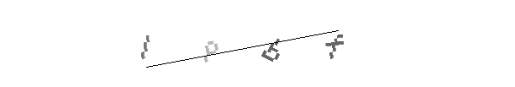

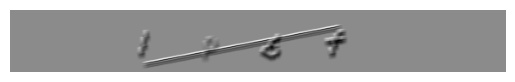

In [6]:
def pca(input: torch.Tensor, target_variance_ratio = 0.99, max_components = 20) -> torch.Tensor:
    U, S, V =  torch.pca_lowrank(input, q=max_components)
    explained_variance = (S**2) / torch.sum(S**2)
    cumulative_explained_variance = torch.cumsum(explained_variance, dim=0)
    n_components = torch.sum(cumulative_explained_variance < target_variance_ratio).item() + 1

    # print(f"Number of components selected to explain {target_variance_ratio * 100}% of variance: {n_components}")
    # # Plot the explained variance vs number of components
    # plt.figure(figsize=(8, 6))
    # plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance.cpu(), marker='o', linestyle='--', color='b')
    # plt.title("Cumulative Explained Variance vs. Number of Components")
    # plt.xlabel("Number of Components")
    # plt.ylabel("Cumulative Explained Variance")
    # plt.grid(True)
    # plt.show()
    # assert 0

    U_reduced = U[:, :n_components]
    S_reduced = S[:n_components]
    V_reduced = V[:, :n_components]

    S_reduced_diag = torch.diag(S_reduced)
    image_reconstructed_flat = torch.mm(U_reduced, torch.mm(S_reduced_diag, V_reduced.T))
    image_reconstructed = image_reconstructed_flat.view(input.shape)

    return image_reconstructed


def klt(input: torch.Tensor, n: int = 8):
    # Ensure the input image has three dimensions (C, M, N)
    assert input.dim() == 3, "Input must be a 3D tensor of shape (C, M, N)"
    C, M, N = input.shape

    # Prepare lists to store the detail images, eigenvalues, and filters for each channel
    all_detail_images = []
    all_eigenvalues = []
    all_filters = []

    for c in range(C):
        # Extract the channel image
        channel_input = input[c]

        # Step 1: Extract nxn patches using a sliding window
        # Use unfold to create sliding windows of size n x n
        patches = channel_input.unfold(0, n, 1).unfold(1, n, 1)  # Shape (M-n+1, N-n+1, n, n)

        # Step 2: Flatten each nxn patch into a 1D vector of size n**2
        # Reshape patches to have each row as a patch of shape (M-n+1)*(N-n+1) x (n*n)
        patches_reshaped = patches.contiguous().view(-1, n * n)  # Population matrix

        # Step 3: Compute covariance matrix of the patches and apply PCA
        # Center the patches by subtracting the mean
        mean = patches_reshaped.mean(dim=0)
        centered_patches = patches_reshaped - mean
        
        # Calculate the covariance matrix
        covariance_matrix = torch.mm(centered_patches.T, centered_patches) / (centered_patches.shape[0] - 1)

        # Compute the eigenvalues and eigenvectors of the covariance matrix
        eigenvalues, eigenvectors = torch.linalg.eigh(covariance_matrix)
        
        # Sort eigenvalues and eigenvectors in descending order of eigenvalues
        idx = torch.argsort(eigenvalues, descending=True)
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]
        
        # Step 4: Reshape each eigenvector into an nxn filter
        filters = eigenvectors.T.view(-1, n, n)  # Reshape each eigenvector to n x n filter

        # Step 5: Apply each filter to the input image
        # Stack filters to apply each as a convolutional kernel
        filters = filters.unsqueeze(1)  # Shape (n*n, 1, n, n) for conv2d application
        channel_input_expanded = channel_input.unsqueeze(0).unsqueeze(0)  # Shape (1, 1, M, N)

        # Convolve each filter with the input image to get the detail images
        detail_images = nn.functional.conv2d(channel_input_expanded, filters, padding=0).squeeze(0)  # Output (n*n, M-n+1, N-n+1)

        # Append results for this channel
        all_detail_images.append(detail_images)
        all_eigenvalues.append(eigenvalues)
        all_filters.append(filters.squeeze(1))

    # Stack the results for all channels
    all_detail_images = torch.stack(all_detail_images)  # Shape (C, n*n, M-n+1, N-n+1)
    all_eigenvalues = torch.stack(all_eigenvalues)  # Shape (C, n*n)
    all_filters = torch.stack(all_filters)  # Shape (C, n*n, n, n)

    return all_detail_images, all_eigenvalues, all_filters


def process_klt(image: torch.Tensor, selected_components=8):
    # orig_background = 
    detail_images, eigenvalues, filters = klt(image, n)
    # print("Detail Images Shape:", detail_images.shape)  # Expected: (C, n*n, M-n+1, N-n+1)
    # print("Eigenvalues Shape:", eigenvalues.shape)  # Expected: (C, n*n)
    # print("Filters Shape:", filters.shape)  # Expected: (C, n*n, n, n)

    # Select top components for preprocessing
    # We take the first few detail images with the highest eigenvalues for each channel
    # This helps retain the most significant features in the image
    
    # Convert detail images to a single channel by summing top components across channels
    # print(detail_images.shape)
    image2 = torch.sum(detail_images[:, :selected_components], dim=1)  # Shape (C, M-n+1, N-n+1)

    # Re-normalize
    minimum = image2.min()
    image2 = (image2 - minimum) / (image2.max() - minimum)
    # background = torch.mode(image2)[0][0][0]
    # image2[image2 == background] = 0.0

    return image2


image = torchvision.io.read_image("train/lpbf-0.png", mode=ImageReadMode.GRAY)
image = image.to(device).float()
n = 8  # Patch size
print(image.shape)
image2 = process_klt(image)

plt.imshow(image[0].cpu().numpy(), cmap='gray')
plt.axis('off')
plt.show()

plt.imshow(image2[0].cpu().numpy(), cmap='gray')
plt.axis('off')
plt.show()

In [7]:
def reduce_gray_levels(input: torch.Tensor, num_levels: int):
    # Quantize the pixel values to the target number of levels
    levels = torch.linspace(0, 1, num_levels, device=input.device)
    input[(levels[-2] < input) & (input < levels[-1]-0.0001)] = levels[-2]
    input = torch.bucketize(input, levels)
    # print(input.flatten().bincount())
    # assert 0
    input = input.float() / (num_levels-1)
    return input

reduce_gray_levels(torch.tensor([0.01, 0.5, 0.99]), 8)

tensor([0.1429, 0.5714, 0.8571])

In [8]:
def grayscale_tensor_to_cv2(tensor: torch.Tensor):
    return tensor.squeeze(0).cpu().numpy().astype(np.uint8)

def grayscale_cv2_to_tensor(image: np.ndarray):
    return torch.from_numpy(image).to(device).float().unsqueeze(0)

def detect_edges(input: torch.Tensor):
    image = grayscale_tensor_to_cv2(input)
    image = cv2.Canny(image, 10, 20, 3)
    return grayscale_cv2_to_tensor(image)

def apply_threshold(input: torch.Tensor):
    # _, thresholded = cv2.threshold(grayscale_tensor_to_cv2(input), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # return grayscale_cv2_to_tensor(thresholded)
    background = torch.mode(input)[0][0][0]
    input[input != background] = 255.0 - background
    return input

def contrast_stretching(input: torch.Tensor):
    C = input.size(0)
    for c in range(C):
        min_val = input[c].min()
        max_val = input[c].max()
        input[c] = (input[c] - min_val) / (max_val - min_val)
    return input

In [9]:
# Resize all images to this size
IMG_HEIGHT = 80
IMG_WIDTH = 780

def crop_image(input: torch.Tensor, background=None):
    # Step 0: Extract the background color
    if background is None:
        background = torch.mode(input)[0][0][0]

    # Step 1: Identify non-background areas (columns and rows)
    grayscale_image = torch.mean(input, dim=0, keepdim=True)
    non_background_columns = torch.any(grayscale_image != background, dim=1).squeeze()
    non_background_rows = torch.any(grayscale_image != background, dim=2).squeeze()

    # Step 2: Find the first and last non-background columns and rows
    non_background_col_indices = torch.nonzero(non_background_columns).squeeze()
    non_background_row_indices = torch.nonzero(non_background_rows).squeeze()

    background_pad = 0
    first_col_idx = max(0, non_background_col_indices.min() - background_pad)
    last_col_idx = non_background_col_indices.max() + background_pad
    first_row_idx = max(0, non_background_row_indices.min() - background_pad)
    last_row_idx = non_background_row_indices.max() + background_pad

    # Step 3: Trim the input tensor to the non-background area
    input = input[:, first_row_idx:last_row_idx+1, first_col_idx:last_col_idx+1]

    return input

def resize_with_same_aspect_ratio(
    input: torch.Tensor,
    background=None,
    random_scale=False,
    random_padding=False,
    img_height=IMG_HEIGHT,
    img_width=IMG_WIDTH,
):
    # Step 0: Extract the background color
    if background is None:
        background = torch.mode(input)[0][0][0]

    C = input.size(0)
    input = crop_image(input, background=background)

    # Step 4: Calculate the original scale and apply random scaling
    orig_height, orig_width = input.size(1), input.size(2)
    max_scale_ratio = min(img_width / orig_width, img_height / orig_height)
    random_scale_ratio = random.uniform(1.0, max_scale_ratio) if random_scale else max_scale_ratio
    new_height = round(orig_height * random_scale_ratio)
    new_width = round(orig_width * random_scale_ratio)

    # Step 5: Resize the image using bilinear interpolation
    input = nn.functional.interpolate(input.unsqueeze(0), size=(new_height, new_width), mode='bilinear').squeeze(0)

    # Step 6: Calculate padding
    pad_height = img_height - new_height
    pad_width = img_width - new_width
    assert pad_height >= 0 and pad_width >= 0, f"new_height: {new_height}, new_width: {new_width}"

    # Step 7: Determine whether to randomize padding amount
    if not random_padding:
        top_pad = pad_height // 2
        bottom_pad = pad_height - top_pad
        left_pad = pad_width // 2
        right_pad = pad_width - left_pad
    else:
        top_pad = random.randint(0, pad_height)
        bottom_pad = pad_height - top_pad
        left_pad = random.randint(0, pad_width)
        right_pad = pad_width - left_pad

    # Step 8: Pad the image to the target size
    input = nn.functional.pad(input, (left_pad, right_pad, top_pad, bottom_pad), value=background)

    # Step 9: Ensure the output image is the target size
    assert tuple(input.shape) == (C, img_height, img_width), f"Unexpected shape: {input.shape}"

    return input

def resize_by_char(input: torch.Tensor, background=None):
    if background is None:
        background = torch.mode(input)[0][0]
    
    assert input.size(0) == 1 # grayscale, 1 channel
    input = input.squeeze(0)

    zero_columns = (input == background).all(dim=0)

    # Step 2: Find indices of non-zero column segments
    non_zero_segments = []
    start = None

    for i, is_zero in enumerate(zero_columns):
        if not is_zero and start is None:
            start = i
        elif is_zero and start is not None:
            non_zero_segments.append(input[:, start:i])
            start = None
    if start is not None:
        non_zero_segments.append(input[:, start:])

    result = []
    zero_column = torch.zeros((IMG_HEIGHT, 1), dtype=input.dtype, device=input.device)
    for i, segment in enumerate(non_zero_segments):
        # print(f\"Segment {i + 1}:\\n{segment}\\n\")
        # print(segment.shape)
        non_background_rows = torch.any(segment != background, dim=1).squeeze()
        non_background_row_indices = torch.nonzero(non_background_rows)      
        first_row_idx = max(0, non_background_row_indices[0]-background)     
        last_row_idx = non_background_row_indices[-1]+background
        segment = segment[first_row_idx:last_row_idx+1]

        # Reshape to target height
        orig_height, orig_width = segment.shape
        scale_ratio = IMG_HEIGHT / orig_height
        new_height = IMG_HEIGHT
        new_width = round(orig_width * scale_ratio)

        # Step 3: Resize the image using bilinear interpolation
        segment = nn.functional.interpolate(segment.unsqueeze(0).unsqueeze(0), size=(new_height, new_width), mode='bilinear').squeeze(0).squeeze(0)

        result.append(segment)
        result.append(zero_column)

    final = torch.cat(result, dim=-1)
    final = resize_with_same_aspect_ratio(final.unsqueeze(0), background=background)
    return final


In [10]:
# Define the mean and standard deviation used for normalization
RGB_MEAN = [0.485, 0.456, 0.406]
RGB_STD = [0.229, 0.224, 0.225]
GRAYSCALE_MEAN = [0.5]
GRAYSCALE_STD = [0.5]
NORM_MEAN = GRAYSCALE_MEAN # Modify this
NORM_STD = GRAYSCALE_STD # Modify this

class CaptchaDataset(Dataset):
    def __init__(self, image_paths, transform=None, transform_before_resize=None, cache_dir=None):
        self.image_paths = image_paths
        labels = paths_to_labels(self.image_paths)
        self.labels = [label.to(device) for label in labels]
        self.images = [None] * len(self.image_paths)
        self.transform = transform
        self.transform_before_resize = transform_before_resize
        # self.gaussian_blur = v2.GaussianBlur(3, 0.2)
        self.sobel_xy = np.array([
            [-2, -1,  0],
            [-1,  0,  1],
            [ 0,  1,  2]]
        )
        self.sobel_yx = np.array([
            [ 2,  1,  0],
            [ 1,  0, -1],
            [ 0, -1, -2]]
        )
        self.laplacian = np.array([
            [-1, -1, -1],
            [-1,  8, -1],
            [-1, -1, -1]]
        )
        self.cache_dir = cache_dir
        # self.cache_dir = None
        if self.cache_dir:
            os.makedirs(self.cache_dir, exist_ok=True)

    def __len__(self):
        return len(self.image_paths)

    def _get_cached_image(self, idx):
        if self.cache_dir:
            cache_filename = os.path.join(self.cache_dir, f"{idx}.pt")
            return cache_filename

    def _load_cached_image(self, cache_filename):
        # Load the image from disk if it's cached
        if self.cache_dir and os.path.exists(cache_filename):
            return torch.load(cache_filename)
        return None

    def _save_image_to_cache(self, idx, image):
        # Save the image to disk cache
        cache_filename = self._get_cached_image(idx)
        torch.save(image, cache_filename)

    def __getitem__(self, idx):
        image = self._load_cached_image(self._get_cached_image(idx))

        if image is None:
            img_path = self.image_paths[idx]
            image = torchvision.io.read_image(img_path, mode=ImageReadMode.RGB)
            # image = torchvision.io.read_image(img_path, mode=ImageReadMode.GRAY)
            image = image.to(device).float()

            # Conv to grayscale using weighted average
            image = (0.30 * image[0] + 0.59 * image[1] + 0.11 * image[2]).unsqueeze(0)

            # Apply inpainting to remove random black lines
            image = masked_median_pool2d(image)

            # Invert image
            image = 255.0 - image

            # Apply canny edge detector
            # edges = detect_edges(image)
            # image = torch.max(image, edges)

            # Apply cv2 filters
            # np_img = grayscale_tensor_to_cv2(image)
            # np_img = cv2.filter2D(np_img, -1, self.sobel_xy) + cv2.filter2D(np_img, -1, self.sobel_yx)
            # np_img = cv2.filter2D(np_img, -1, self.laplacian)
            # image = grayscale_cv2_to_tensor(np_img)
            # print(image.mode()[0][0][0])
            # assert 0

            if self.transform_before_resize:
                image = self.transform_before_resize(image)

            # Apply custom resize function
            image = resize_with_same_aspect_ratio(image, background=0.0)
            # image = resize_by_char(image, background=0.0)

            # Apply normalization
            image /= 255.0 # Scale from [0,255] to [0,1]

            # Apply graylevel reduction
            # image = reduce_gray_levels(image, 64)
            # image = apply_threshold(image)
            image = contrast_stretching(image)

            # image = process_klt(image)

            # Perform PCA
            # image_flattened = image.view(-1, image.size(-1))
            # image = pca(image_flattened).view(image.shape)

            # Cache the preprocessed image
            if self.cache_dir:
                self._save_image_to_cache(idx, image.cpu())

        # Apply any additional transforms after loading or caching
        image = image.to(device)
        if self.transform:
            image = self.transform(image)

        # image = v2.Normalize(mean=NORM_MEAN, std=NORM_STD)(image)
        return image, self.labels[idx]

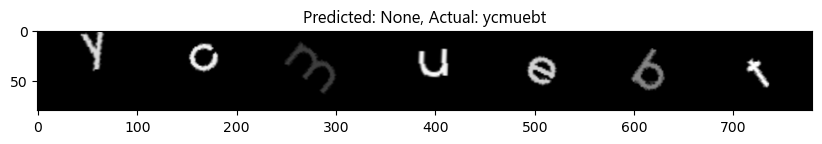

Input channels: 1
train size: 7200
val size: 800
test size: 2000


In [11]:
from typing import Optional

from torchvision.transforms import InterpolationMode

TRAIN_VAL_SPLIT = [0.90, 0.10]
BATCH_SIZE = 32

# Image transformation
transform_before_resize = v2.Compose([
    v2.RandomPerspective(distortion_scale=0.25, p=1/4),
])
transform = v2.Compose([
    # v2.RandomApply([
    #     # v2.ColorJitter((1.0,1.0), (2.0,2.0)),
    #     # v2.RandomRotation(10),
    # ], p=0.5),
    # v2.ColorJitter((1.0,1.0), (2.0,2.0)),

    v2.RandomPerspective(distortion_scale=0.25, p=1/4),
    v2.RandomErasing(p=1/4, scale=(0.1, 0.2), ratio=(0.5, 1.5), value=0.0),
    v2.RandomAffine(degrees=3, translate=(0.0, 0.1), scale=(0.75, 1.10), interpolation=InterpolationMode.BILINEAR),
    v2.RandomAutocontrast(p=1/4),
    v2.RandomAdjustSharpness(1.5, p=1/4),
    # v2.RandomEqualize(p=1/4),
])
# transform = None # Disable transforms
transform_before_resize = None # cannot use with cache

train_folders = ["train/"]
test_folders = ["test/"]
if INCLUDE_REMOVED:
    if USE_RELABELLED:
        train_folders.append("train_removed_relabelled/")
    else:
        train_folders.append("train_removed/")
    test_folders.append("test_removed/")

# Randomly split train and val sets
image_paths = get_image_paths(train_folders)
random.shuffle(image_paths)
train_n = round(TRAIN_VAL_SPLIT[0] * len(image_paths))
train_image_paths, val_image_paths = image_paths[:train_n], image_paths[train_n:]

train_dataset = CaptchaDataset(image_paths=train_image_paths, transform=transform, transform_before_resize=transform_before_resize, cache_dir="__train_cache__/")
val_dataset = CaptchaDataset(image_paths=val_image_paths, cache_dir="__val_cache__/")  # No transforms on val dataset
test_dataset = CaptchaDataset(image_paths=get_image_paths(test_folders), cache_dir="__test_cache__/")  # No transforms on test dataset

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Un-normalize the image
def unnormalize(image, mean=NORM_MEAN, std=NORM_STD):
    mean = torch.tensor(mean).view(-1, 1, 1)
    std = torch.tensor(std).view(-1, 1, 1)
    # image = image * std + mean  # Reverse normalization
    return image * 255.0


def display(
    image: torch.Tensor,
    actual_label: Optional[torch.Tensor] = None,
    predicted_label: Optional[torch.Tensor] = None
):
    # Display a sample image
    image = image.cpu()
    image = unnormalize(image)
    plt.figure(figsize=(10, 4))
    # plt.axis('off')
    plt.imshow(image.int().permute(1, 2, 0).numpy(), cmap='gray' if image.size(0) == 1 else None)

    if actual_label is not None:
        actual_label = ''.join(VOCAB_LIST[i] for i in list(actual_label.int()) if i != PADDING_VALUE)
    if predicted_label is not None:
        predicted_label = ''.join(VOCAB_LIST[i] for i in list(predicted_label.int()) if i != PADDING_VALUE)

    plt.title(f"Predicted: {predicted_label}, Actual: {actual_label}", fontname=['Segoe UI Emoji', 'Cambria'])
    plt.show()


images, labels = next(iter(train_dataloader))
# print(images[0])
display(images[0], actual_label=labels[0]) # extract first sample from batch

input_channels = images.shape[1] # Get the no. of channels in the image
print("Input channels:", input_channels)
print("train size:", len(train_dataset))
print("val size:", len(val_dataset))
print("test size:", len(test_dataset))

In [12]:
unnormalize(images[0].cpu()).int().flatten().bincount()

tensor([57671,   139,   104,    90,    83,    55,    60,    40,    55,    49,
           50,    43,    39,    37,    38,    33,    41,    27,    31,    30,
           35,    19,    16,    34,    31,    33,    22,    32,    29,    23,
           25,    19,    22,    32,    15,    15,    32,    23,    20,    26,
           21,    24,    21,    31,    23,    24,    26,    24,    27,    24,
           20,    20,    24,    26,    28,    17,    34,    30,    48,    40,
           42,    74,   103,    19,     8,    11,    10,     8,    12,    10,
           11,    10,     9,    15,     4,    11,    14,     9,     5,    14,
            8,     7,    15,    14,     6,     9,    11,     6,    11,    12,
           13,     9,     7,    13,    13,    14,    15,    10,    14,    14,
           21,    15,     4,    17,    12,    15,    11,    12,    12,    13,
           14,    10,    17,    13,    13,     7,    12,     9,     6,    19,
           14,    15,    17,    15,    11,    18,    18,    22, 

In [13]:
# Ref: https://github.com/PaddlePaddle/PaddleOCR/blob/main/ppocr/losses/rec_ctc_loss.py
class FocalCTCLoss(nn.CTCLoss):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, reduction='none', **kwargs)

    def forward(self, *args, **kwargs):
        loss: torch.Tensor = super().forward(*args, **kwargs)
        # Focal updates
        weight = (1.0 - (-loss).exp()).square()
        loss = (loss * weight).mean()
        return loss


def compute_loss(criterion, logits: torch.Tensor, labels: torch.Tensor):
    batch_size, input_len, num_classes = logits.size()

    log_probs = logits.log_softmax(2).permute(1, 0, 2) # CTCLoss expects (T, N, C)
    input_lengths = torch.full(size=(batch_size,), fill_value=input_len, dtype=torch.long, device=device)
    target_lengths = (labels != PADDING_VALUE).count_nonzero(dim=1)

    # Cast to float as CTCLoss only supports fp32 log_probs
    return criterion(log_probs.float(), labels, input_lengths, target_lengths)


def greedy_decode(logits: torch.Tensor):
    # logits: (batch_size, seq_len, num_classes)
    x = logits.argmax(2) # y_pred: (batch_size, seq_len)
    _, indices = x.unique_consecutive(return_inverse=True)
    indices -= indices.min(dim=1, keepdims=True)[0]
    x = torch.full_like(x, PADDING_VALUE, device=x.device).scatter_(1, indices, x)
    mask = (x != PADDING_VALUE)
    summed_mask = mask.count_nonzero(dim=1)
    x = torch.split(x[mask], summed_mask.tolist())
    x = torch.nn.utils.rnn.pad_sequence(x, batch_first=True, padding_value=PADDING_VALUE)
    x = torch.nn.functional.pad(x, (0, MAX_LABEL_LEN-x.size(1)), value=PADDING_VALUE)
    return x

In [14]:
from datetime import datetime

from IPython.display import clear_output


def plot_loss(train_losses=None, val_losses=None, val_accs=None, val_char_accs=None, lr=None, is_last=False, clear=True):
    epochs = list(range(1, len(train_losses)+1))
    fig, ax1 = plt.subplots(figsize=(10,6), dpi=200)
    ax2 = ax1.twinx()
    # plt.xticks(epochs)
    ax1.xaxis.get_major_locator().set_params(integer=True)
    ax2.xaxis.get_major_locator().set_params(integer=True)
    ax1.yaxis.get_major_locator().set_params(integer=True)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax2.set_ylabel('Accuracy')
    ax1.set_ylim(0, max([*train_losses, *val_losses, *val_accs, *val_char_accs]))
    # ax1.yscale('log')
    ax2.set_ylim(0.0, 1.0)

    if train_losses:
        ax1.plot(epochs, train_losses, marker=None, label='Training Loss', color='tab:blue')
    if val_losses:
        ax1.plot(epochs, val_losses, marker=None, label='Validation Loss', color='tab:orange')
    if val_accs:
        ax2.plot(epochs, val_accs, marker=None, label='Validation Accuracy', color='tab:green')
    if val_char_accs:
        ax2.plot(epochs, val_char_accs, marker=None, label='Validation Character Accuracy', color='tab:red')
    if lr:
        plt.title(f'lr = {lr:.6f}')

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc="lower right", bbox_to_anchor=(1, 0.1))

    if clear:
        clear_output(wait=True)
    plt.show()
    if is_last:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S%f")[:-3]
        save_path = f'{timestamp}.png'
        fig.savefig(save_path)

In [15]:
from sklearn.metrics import confusion_matrix

train_losses = []
val_losses = []
val_accs = []
val_char_accs = []

def train(
    model,
    train_dataloader,
    criterion,
    optimizer,
    val_dataloader=None,
    epochs=10,
    compute_loss=compute_loss,
    greedy_decode=greedy_decode,
    state_dict_name='model.pth',
):
    best_val_loss = float('inf')
    best_val_acc = 0.0
    best_epoch = 0
    for epoch in range(1, epochs+1):
        model.train()
        total_loss = 0.0
        num_samples = 0
        for images, labels in train_dataloader:
            images = images.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            logits: torch.Tensor = model(images)
            # print(logits.shape)
            # print(labels.shape)
            # assert 0
            # Compute loss
            loss = compute_loss(criterion, logits, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # the criterion computes the mean across the batch by default
            # the last batch might not have the same batch size as the other batches
            # this way of loss calculation is more accurate
            total_loss += loss.item() * images.size(0)
            num_samples += images.size(0) # current batch size
            # break

        train_loss = total_loss / num_samples

        val_loss = val_acc = val_char_acc = None
        if val_dataloader is not None:
            metrics = test(model, val_dataloader, criterion=criterion, compute_loss=compute_loss, greedy_decode=greedy_decode)
            val_loss, val_acc, val_char_acc = metrics['loss'], metrics['acc'], metrics['char_acc']

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        val_char_accs.append(val_char_acc)

        plot_loss(
            train_losses=train_losses,
            val_losses=val_losses,
            val_accs=val_accs,
            val_char_accs=val_char_accs,
            is_last=(epoch == epochs)
        )
        print(f"Epoch [{epoch}/{epochs}], train_loss: {train_loss:.2f}, val_loss: {val_loss:.2f}, val_acc: {val_acc:.2f}, val_char_acc: {val_char_acc:.2f}")

        # if val_acc is not None and val_acc >= best_val_acc:
        #     # Early stopping by accuracy
        #     best_val_acc = val_acc
        if val_loss is not None and val_loss <= best_val_loss:
            # Early stopping by loss
            best_val_loss = val_loss
            best_epoch = epoch
            torch.save(model.state_dict(), state_dict_name)
            print(f"Saved model state dict to {state_dict_name}")

        else:
            print(f"Best epoch: {best_epoch}, val_loss: {best_val_loss:.2f}")


def test(
    model,
    dataloader,
    criterion=None,
    return_confusion_matrix=False,
    compute_loss=compute_loss,
    greedy_decode=greedy_decode,
) -> float:
    model.eval()
    total_loss = 0.0
    num_samples = 0
    num_correct = 0
    num_chars_correct = 0
    total_chars = 0

    if return_confusion_matrix:
        all_labels = torch.tensor([], dtype=torch.long, device=device)
        all_predictions = torch.tensor([], dtype=torch.long, device=device)

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            logits: torch.Tensor = model(images)

            # Compute loss
            if criterion:
                loss = compute_loss(criterion, logits, labels)
                total_loss += loss.item() * images.size(0)

            # Compare predictions with true labels
            predictions = Y_PRED_TO_FINAL_PRED[greedy_decode(logits)]
            correctly_predicted: torch.Tensor = (predictions == labels)

            labels_are_padding = (labels == PADDING_VALUE)
            labels_are_not_padding = ~labels_are_padding
            # Add correctly predicted chars
            num_chars_correct += (correctly_predicted & labels_are_not_padding).count_nonzero().item()
            # Subtract extra predicted characters
            # num_chars_correct -= (labels_are_padding & (predictions != PADDING_VALUE)).count_nonzero().item()

            num_samples += images.size(0)
            total_chars += labels_are_not_padding.count_nonzero().item()

            if not isinstance(criterion, nn.CrossEntropyLoss):
                # Count correctly predicted captchas
                num_correct += correctly_predicted.all(dim=1).sum().item()

            else:
                pass
                # TODO: Count correctly predicted captchas
                # num_correct += ...

            # Collect data for confusion matrix if requested
            if return_confusion_matrix:
                all_labels = torch.cat([all_labels, labels.flatten()])
                all_predictions = torch.cat([all_predictions, predictions.flatten()])

    metrics = {
        'loss': total_loss / num_samples if criterion else None,
        'acc': num_correct / num_samples,
        'char_acc': num_chars_correct / total_chars,
        'conf_matrix': confusion_matrix(all_labels.cpu(), all_predictions.cpu()) if return_confusion_matrix else None,
    }
    return metrics

In [16]:
class AttentionLayer(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.query_layer = nn.Linear(hidden_dim, hidden_dim)
        self.key_layer = nn.Linear(hidden_dim, hidden_dim)
        self.value_layer = nn.Linear(hidden_dim, hidden_dim)
        self.scale = hidden_dim ** 0.5

    def forward(self, lstm_outputs):
        # LSTM outputs: (B, T, hidden_dim)
        queries = self.query_layer(lstm_outputs)  # (B, T, hidden_dim)
        keys = self.key_layer(lstm_outputs)  # (B, T, hidden_dim)
        values = self.value_layer(lstm_outputs)  # (B, T, hidden_dim)

        # Compute attention scores
        scores = torch.matmul(queries, keys.transpose(1, 2)) / self.scale  # (B, T, T)
        attn_weights = nn.functional.softmax(scores, dim=-1)  # (B, T, T)

        # Compute context vector
        context = torch.matmul(attn_weights, values)  # (B, T, hidden_dim)
        return context, attn_weights


class CRNN(nn.Module):
    def __init__(self, num_classes, input_channels):  # 26 letters + 10 digits = 36 classes
        super().__init__()
        # CNN layers
        first_layer_channels = 32
        n_cnn_layers = 3
        in_channels = input_channels
        out_channels = None
        cnn_layers = [
            # nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding='same'),
            # nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding='same'),
            # nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding='same'),
        ]
        for i in range(1, n_cnn_layers+1):
            out_channels = first_layer_channels if i == 1 else in_channels * 2
            cnn_layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=5, stride=1, padding='same')),
            cnn_layers.append(nn.MaxPool2d(kernel_size=2, stride=2)),
            # cnn_layers.append(nn.AvgPool2d(kernel_size=2, stride=2)),
            cnn_layers.append(nn.BatchNorm2d(out_channels)),
            cnn_layers.append(nn.ReLU()),
            cnn_layers.append(nn.BatchNorm2d(out_channels)),
            cnn_layers.append(nn.Dropout2d(p=1/5)),
            in_channels = out_channels

        self.cnn = nn.Sequential(
            *cnn_layers,
            # nn.Dropout2d(p=0.25),
        )

        num_features = 1280
        rnn_hidden_size = 512
        rnn_num_layers = 2
        bidirectional = True

        self.rnn = nn.Sequential(
            nn.LSTM(
                input_size=num_features,
                hidden_size=rnn_hidden_size,
                num_layers=rnn_num_layers,
                batch_first=True,
                dropout=1/5,
                bidirectional=bidirectional
            ),
        )

        num_features = rnn_hidden_size * (2 if bidirectional else 1)
        # num_features is usually 1024

        self.attention = AttentionLayer(hidden_dim=num_features)

        self.fc = nn.Sequential(
            # nn.Dropout(p=0.15),
            nn.Linear(num_features, num_classes)
        )

    def forward(self, images: torch.Tensor) -> torch.Tensor:
        x = self.cnn(images)
        N, C, h, w = x.size()
        x = x.permute(0, 3, 1, 2)
        x = x.view(N, w, -1) # -1 indcates C * h
        x, _ = self.rnn(x)

        attn_context, _ = self.attention(x)  # (B, T, hidden_dim)
        logits = self.fc(attn_context)  # (B, T, num_classes)
        return logits

        # x = self.fc(x)
        # return x

In [17]:
from torchinfo import summary

# Initialize model
model = CRNN(num_classes=NUM_CLASSES, input_channels=input_channels)
model = model.to(device)

# Resume from checkpoint. Comment out to start training from scratch
# state_dict = torch.load("model.pth", map_location=device)
# model.load_state_dict(state_dict)
print("Input size:", images.shape)
print(summary(model, input_size=images.shape, device=device))

# model = torch.compile(model)

Input size: torch.Size([32, 1, 80, 780])
Layer (type:depth-idx)                   Output Shape              Param #
CRNN                                     [32, 97, 37]              --
├─Sequential: 1-1                        [32, 128, 10, 97]         --
│    └─Conv2d: 2-1                       [32, 32, 80, 780]         832
│    └─MaxPool2d: 2-2                    [32, 32, 40, 390]         --
│    └─BatchNorm2d: 2-3                  [32, 32, 40, 390]         64
│    └─ReLU: 2-4                         [32, 32, 40, 390]         --
│    └─BatchNorm2d: 2-5                  [32, 32, 40, 390]         64
│    └─Dropout2d: 2-6                    [32, 32, 40, 390]         --
│    └─Conv2d: 2-7                       [32, 64, 40, 390]         51,264
│    └─MaxPool2d: 2-8                    [32, 64, 20, 195]         --
│    └─BatchNorm2d: 2-9                  [32, 64, 20, 195]         128
│    └─ReLU: 2-10                        [32, 64, 20, 195]         --
│    └─BatchNorm2d: 2-11              

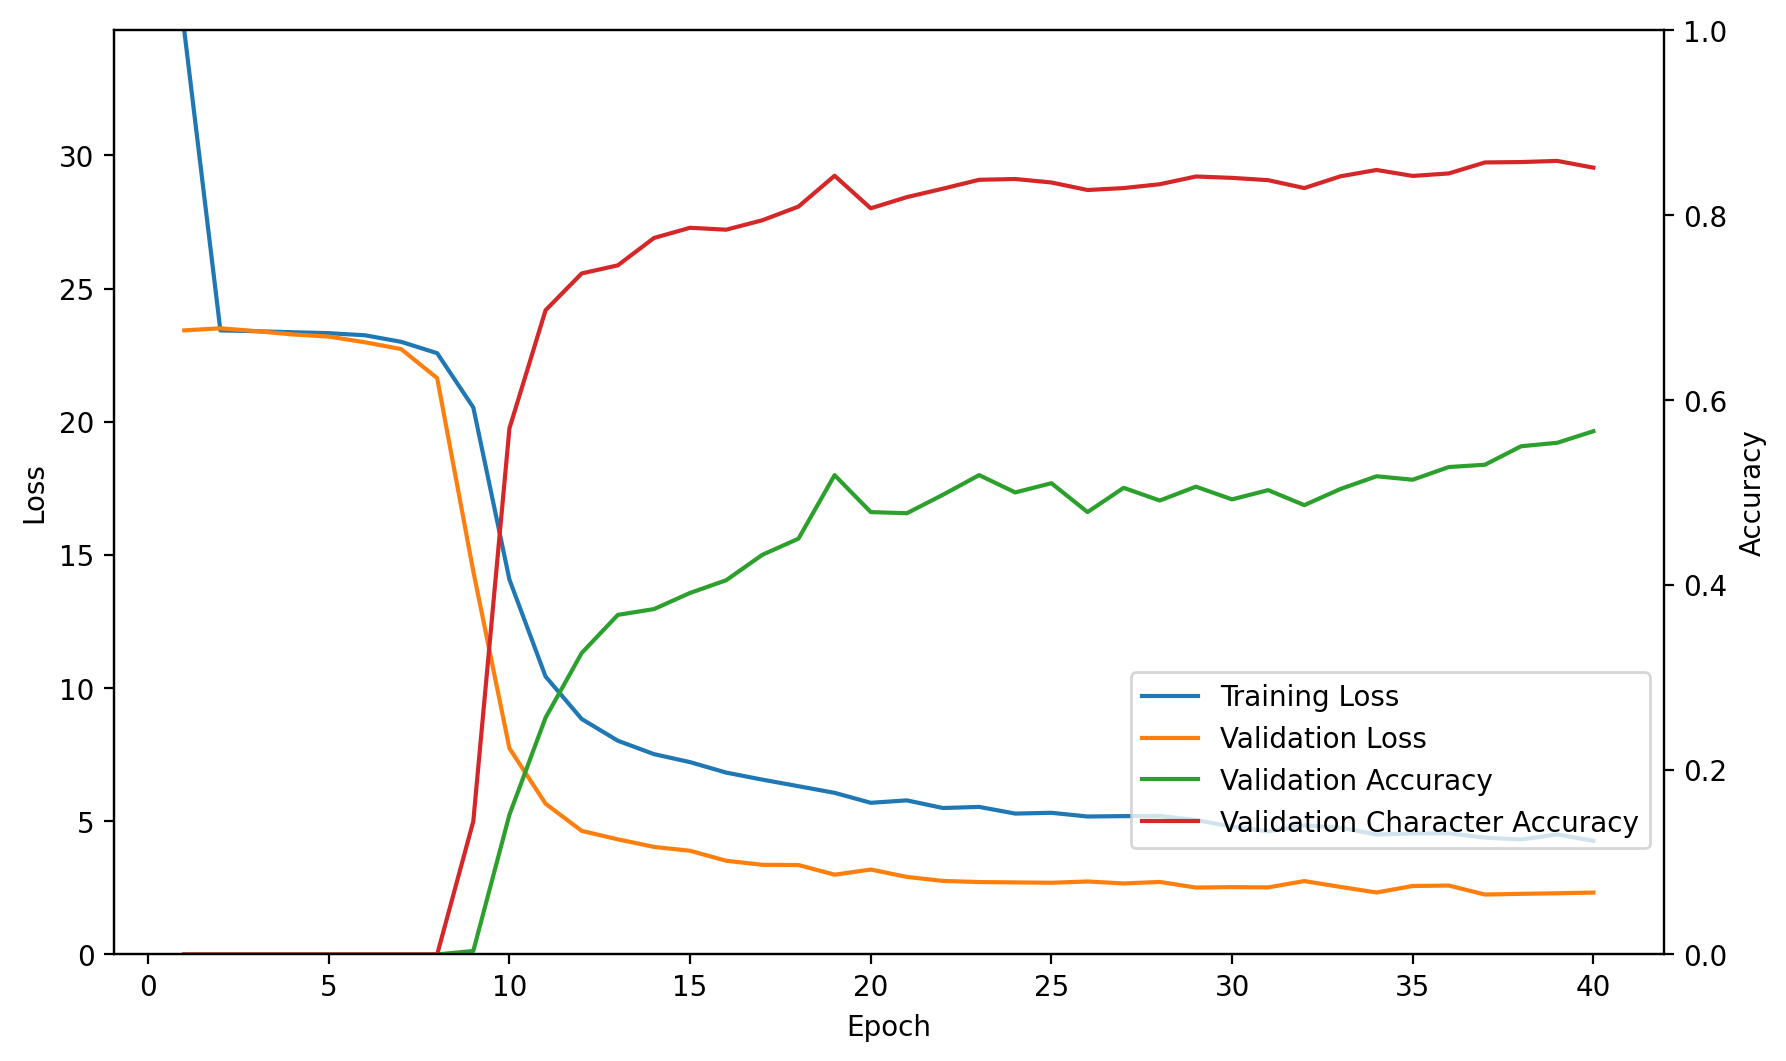

Epoch [40/200], train_loss: 4.27, val_loss: 2.32, val_acc: 0.57, val_char_acc: 0.85
Best epoch: 37, val_loss: 2.25


KeyboardInterrupt: 

In [18]:
import torch.optim as optim

from adabound import AdaBound

# Loss and optimizer
# criterion = nn.CrossEntropyLoss(ignore_index=IGNORE_INDEX).to(device)
# criterion = nn.CTCLoss(blank=PADDING_VALUE).to(device)
criterion = FocalCTCLoss(blank=PADDING_VALUE).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, amsgrad=True, weight_decay=1e-6, fused=True)
optimizer = AdaBound(model.parameters(), lr=1e-4, amsbound=True, weight_decay=1e-6)

# Train the model
train(model, train_dataloader, criterion, optimizer, val_dataloader=val_dataloader, epochs=200)

In [ ]:
import gc

gc.collect()
torch.cuda.empty_cache()

In [ ]:
# Testing block
# Load from best checkpoint
model_best = CRNN(num_classes=NUM_CLASSES, input_channels=input_channels)
model_best = model.to(device)
# state_dict = torch.load("model_69a9ea.pth", map_location=device)
state_dict = torch.load("model.pth", map_location=device)
model_best.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
train_metrics = test(model_best, train_dataloader)
print(f"train_acc: {train_metrics['acc'] * 100:.2f}%, train_char_acc: {train_metrics['char_acc'] * 100:.2f}%")

val_metrics = test(model_best, val_dataloader)
print(f"val_acc: {val_metrics['acc'] * 100:.2f}%, val_char_acc: {val_metrics['char_acc'] * 100:.2f}%")

test_metrics = test(model_best, test_dataloader, return_confusion_matrix=True)
print(f"test_acc: {test_metrics['acc'] * 100:.2f}%, test_char_acc: {test_metrics['char_acc'] * 100:.2f}%")

train_acc: 61.00%, train_char_acc: 86.37%
val_acc: 61.12%, val_char_acc: 89.26%
test_acc: 62.05%, test_char_acc: 89.57%


In [ ]:
# test and print confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm

vocablist = VOCAB_LIST[:36]  # padding token is blank
conf_mat = test_metrics['conf_matrix']

plt.figure(figsize=(15, 12))
sns.heatmap(
    conf_mat,
    annot=True,
    fmt='d', 
    cmap='Blues',
    xticklabels=vocablist,
    yticklabels=vocablist,
    annot_kws={"size": 7},
    square=True,
    norm=LogNorm()
)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Initialize lists to hold precision and recall for each class
precision = []
recall = []

# Calculate precision and recall for each class
for i in range(len(conf_mat)):
    true_positives = conf_mat[i, i]
    false_positives = conf_mat[:, i].sum() - true_positives
    false_negatives = conf_mat[i, :].sum() - true_positives

    # Avoid division by zero
    class_precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    class_recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

    precision.append(class_precision)
    recall.append(class_recall)

# Display results
for i, (p, r) in enumerate(zip(precision, recall)):
    print(f"Class {i}: Precision = {p:.2f}, Recall = {r:.2f}")

In [ ]:
# Model playground
model.eval()
shuffled_test_dataloader = DataLoader(val_dataloader.dataset, batch_size=1, shuffle=True)
images, labels = next(iter(shuffled_test_dataloader))
logits = model(images)
predictions = greedy_decode(logits)
display(images[0], actual_label=labels[0], predicted_label=Y_PRED_TO_FINAL_PRED[predictions[0]])